<h1> Main Goal </h1>
The main problem of this challenge is to create the shortest ansatz circuit that accurately represents <br>
the ground state of the given problem , in this case LiH(Lithium Hydride) molecule.<br>

The main problem can be divided into two sub problems<br>
1. Reduce the number of qubits.<br>
2. Optimize the ansatz.<br>

First, we will tackle the problem of reducing the number of qubits problem.<br>
Let's get started.<br>

In [1]:
#run this cell if you do not have depedencies installed.(uncomment the following line to run.)
#!pip install -r requirements.txt

In [2]:
from qiskit_nature.drivers import PySCFDriver
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter
from qiskit_nature.circuit.library import HartreeFock
from qiskit.circuit.library import TwoLocal
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD
from qiskit import Aer
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
import numpy as np
from qiskit.algorithms import VQE
from IPython.display import display, clear_output

<h1> 1. Driver </h1>
By running driver , we acquire all the necessary information about the LiH molecule <br>
needed to run quantum algorithm

In [3]:
molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'
driver = PySCFDriver(atom=molecule)
qmolecule = driver.run()


<h1>2. ElectronicStructureProblem </h1>
By applying ElectronicStructureProblem we get the list of fermionic operators before mapping them to qubits <br>

In [4]:
problem = ElectronicStructureProblem(driver)

# Generate the second-quantized operators
second_q_ops = problem.second_q_ops()

# Hamiltonianmo
main_op = second_q_ops[0]

<h1> 3. Qubit Converter </h1>
Qiskit provides various mapping schemes. We will use 'ParityMapper' mainly because it supports<br>'two_qubit_reduction' which we will see shortly in application.<br>

In [5]:
# Setup the mapper and qubit converter
mapper_type = 'ParityMapper'

if mapper_type == 'ParityMapper':
    mapper = ParityMapper()
elif mapper_type == 'JordanWignerMapper':
    mapper = JordanWignerMapper()
elif mapper_type == 'BravyiKitaevMapper':
    mapper = BravyiKitaevMapper()

converter = QubitConverter(mapper=mapper,two_qubit_reduction = False)

# The fermionic operators are mapped to qubit operators
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
qubit_op = converter.convert(main_op, num_particles=num_particles)

<h1> 4.Number of qubits reduction </h1>
Let's see the number of qubits without any optimizations

In [6]:
print(f'The number of qubits without optimization is {qubit_op.num_qubits}')

The number of qubits without optimization is 12


So, the number of qubits is 12 now, let's see how we can reduce it.<br>

First thing we can do is assign the 'two_qubit_reduction' parameter <br>
of 'QubitConverter' to 'True' and that will reduce the num_qubits by 2.<br><br>

We will be reusing codes from above cells with some modifications.<br>


In [7]:
# Setup the mapper and qubit converter
mapper_type = 'ParityMapper'

if mapper_type == 'ParityMapper':
    mapper = ParityMapper()
elif mapper_type == 'JordanWignerMapper':
    mapper = JordanWignerMapper()
elif mapper_type == 'BravyiKitaevMapper':
    mapper = BravyiKitaevMapper()

converter = QubitConverter(mapper=mapper,two_qubit_reduction = True)

# The fermionic operators are mapped to qubit operators
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
qubit_op = converter.convert(main_op, num_particles=num_particles)

In [8]:
print(f'The number of qubits after two_qubit_reduction is {qubit_op.num_qubits}')

The number of qubits after two_qubit_reduction is 10


As we can see, the number of qubits has reduced to 10, now we can further reduce the number of qubits by <br>
freezing the core electrons that do not contribute significantly to chemistry and also by applying <br>'remove_orbitals'

<h3> 'remove_orbitals' </h3>
I could have spend more time finding the exact orbitals necessary to remove here but <br>
after quick hit and trial method , I found out the orbitals to be removed are 3 and 4 <br> <br>
Without remove_orbitals the num_of_qubits is 8 and after applying it reduces to 4.


In [9]:
from qiskit_nature.transformers import FreezeCoreTransformer
problem = ElectronicStructureProblem(driver,q_molecule_transformers = [FreezeCoreTransformer(freeze_core = True,
                                                                                            remove_orbitals = [3,4])])

# Generate the second-quantized operators
second_q_ops = problem.second_q_ops()

# Hamiltonianmo
main_op = second_q_ops[0]

In [10]:
# Setup the mapper and qubit converter
mapper_type = 'ParityMapper'

if mapper_type == 'ParityMapper':
    mapper = ParityMapper()
elif mapper_type == 'JordanWignerMapper':
    mapper = JordanWignerMapper()
elif mapper_type == 'BravyiKitaevMapper':
    mapper = BravyiKitaevMapper()

converter = QubitConverter(mapper=mapper,two_qubit_reduction = True)

# The fermionic operators are mapped to qubit operators
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
qubit_op = converter.convert(main_op, num_particles=num_particles)

Now, let's see the number of qubits after we have applied two_qubit_reduction, freeze_core and remove_orbitals.

In [11]:
print(f'The number of qubits after  is {qubit_op.num_qubits}')

The number of qubits after  is 4


<h1> 5. z2symmetries reduction </h1>
Now, the only optimization remaining is to apply the 'z2symmetry_reduction' <br>
and this can be done in the following way.<br>

In [12]:
# Setup the mapper and qubit converter
mapper_type = 'ParityMapper'

if mapper_type == 'ParityMapper':
    mapper = ParityMapper()
elif mapper_type == 'JordanWignerMapper':
    mapper = JordanWignerMapper()
elif mapper_type == 'BravyiKitaevMapper':
    mapper = BravyiKitaevMapper()

converter = QubitConverter(mapper=mapper,two_qubit_reduction = True,z2symmetry_reduction = [1,1])

# The fermionic operators are mapped to qubit operators
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
qubit_op = converter.convert(main_op, num_particles=num_particles)

One thing to be careful about z2symmetry_reduction is that the length of array parameter in the <br>
'z2symmetry reduction' and 'remove_orbitals' should be same. In our case both are of length 2.<br>
<br>
In z2symmetry_reduction = [1,1] , we can pass either 1 or -1. '-1' means we will not apply z2symmetry_reduction<b2> and '1' means we will apply.

<h1> 6. Initial State </h1>
HartreeFock is a good initial state and since we are already provided with that we will use it <br>
without any modifications.<br>

In [13]:
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)

<h5> Let's inspect how the intial state looks </h5>


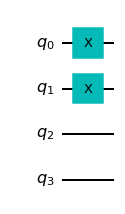

In [14]:
init_state.draw('mpl')

<h1>7. Exact Eignesolver </h1>
Now, let us see how much is the exact ground state energy with exact diagonalization of the Hamiltonian matrix.<br>

In [15]:
def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])
print("Exact electronic energy", exact_energy)
print(result_exact)

Exact electronic energy -1.0887060157347412
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.907396311316
  - computed part:      -1.088706015735
  - FreezeCoreTransformer extracted energy part: -7.818690295581
~ Nuclear repulsion energy (Hartree): 1.025934879643
> Total ground state energy (Hartree): -7.881461431673
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  2.92416221]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  4.76300889]
    - computed part:      [0.0  0.0  4.76695575]
    - FreezeCoreTransformer extracted energy part: [0.0  0.0  -0.00394686]
  > Dipole moment (a.u.): [0.0  0.0  -1.83884668]  Total: 1.83884668
                 (debye): [0.0  0.0  -4.67388163]  Total: 4.67388163
 


<h1> 8. Backend </h1>
We will use statevector_simulator backend for this challenge.

In [16]:
backend = Aer.get_backend('statevector_simulator')

<h1>9. Choice of Optimizers </h1>
We have a few optimizers to choose from.<br>
The following cell runs all optimizer one by one and then print the result for each one.<br>
After that we will choose the best one.<br>
<i> We will use default ansatz to run this optimizer test. </i><br>

In [17]:
maxiter = 1000
#-------ansatz part---------
# Single qubit rotations that are placed on all qubits with independent parameters
rotation_blocks = ['ry','rz']
# Entangling gates
entanglement_blocks = ['cx']
# How the qubits are entangled 
entanglement = 'full'
# Repetitions of rotation_blocks + entanglement_blocks with independent parameters
repetitions = 5
# Skip the final rotation_blocks layer
skip_final_rotation_layer = True
ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                  entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)

##---------optimizer part---------------
optimizers ={'COBLYA':COBYLA(maxiter=maxiter),
             'L_BFGS_B':L_BFGS_B(maxfun=maxiter),
             'SPSA':SPSA(maxiter=maxiter),
             'SLSQP':SLSQP(maxiter= maxiter)}
for key,val in optimizers.items():
    # Set initial parameters of the ansatz
    # We choose a fixed small displacement 
    # So all participants start from similar starting point
    try:
        initial_point = [0.01] * len(ansatz.ordered_parameters)
    except:
        initial_point = [0.01] * ansatz.num_parameters

    algorithm = VQE(ansatz,
                    optimizer=val,
                    quantum_instance=backend,
                    initial_point=initial_point)

    result = algorithm.compute_minimum_eigenvalue(qubit_op)
    print(f'{key}  Optimal Value:{result.optimal_value}   Optimizer time : {result.optimizer_time}')

COBLYA  Optimal Value:-1.0864747794534508   Optimizer time : 20.36427977704443
L_BFGS_B  Optimal Value:-1.0858690710762091   Optimizer time : 18.651083620963618
SPSA  Optimal Value:-1.0787876193001291   Optimizer time : 39.48127787606791
SLSQP  Optimal Value:-1.0886964512937993   Optimizer time : 46.67370682791807


<h6>So, we find out that 'SLSQP' optimizer is the best one for us and we will be using that one.</h6>

<h1>10. Ansatz </h1>
Now, the only thing remaining is to optimize the ansatz.<br><br>
We also have a few ansatz type to choose from.<br><br>
<i>The main thing to keep in mind is that we want the cost i.e. number of CNOTs to be <br>
as low as possible while keeping the error in acceptable range.</i>
After some calculations, I prepared the following table which shows the statistics for <br>
various ansatz

In [18]:
import pandas as pd
df = pd.read_csv('ansatz_comparison.csv')
df[['Ansatz Type','Score','Error']]

,Ansatz Type,Score,Error
0,UCCSD,172,0.000019
1,PUCCD,80,4.218935
2,SUCCD,120,2.241383
3,TwoLocal,30,0.053410


If number of cnots was not as issue, it would have been a different story but <br>since the number of cnots
    is a crucial factor we choose <i> TwoLocal </i>

<h1> 11. Reducing the cost </h1>
<br><br>Since we have chosen <i>TwoLocal</i> as our ansatz and <i>SLSQP</i> as our optimizer,<br>
only thing remaining to do is reduce the cost and possibly bring it to lowest possible score <br>
in our case <i> 3 </i>.

Let's start by changing the various parameters of TwoLocal starting with<br>
<h4>Entanglement </h4>
For entanglement, we can pass one of following values ['full','linear','circular','sca'] <br>
Let's see which scheme provides best score within acepted error range.

In [19]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
entanglement_params = ['full','linear','circular','sca']

#helper function to count the no.of cnots
def count_cnots(ansatz):
    pass_ = Unroller(['u', 'cx'])
    pm = PassManager(pass_)
    ansatz_tp = pm.run(ansatz)
    cnots = ansatz_tp.count_ops()['cx']
    return cnots



#optimizer
optimizer = SLSQP(maxiter = 1000)


#ansatz
# Single qubit rotations that are placed on all qubits with independent parameters
rotation_blocks = ['ry','rz']
# Entangling gates
entanglement_blocks = ['cx']
# How the qubits are entangled 
# Repetitions of rotation_blocks + entanglement_blocks with independent parameters
repetitions = 5
# Skip the final rotation_blocks layer
skip_final_rotation_layer = True

for each_params in entanglement_params:
    ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                  entanglement=each_params, skip_final_rotation_layer=skip_final_rotation_layer)
    try:
        initial_point = [0.01] * len(ansatz.ordered_parameters)
    except:
        initial_point = [0.01] * ansatz.num_parameters

    algorithm = VQE(ansatz,
                    optimizer = optimizer,
                    quantum_instance = backend,
                    initial_point = initial_point)

    result = algorithm.compute_minimum_eigenvalue(qubit_op)
    cnots  = count_cnots(ansatz)
    error = (result.optimal_value - exact_energy) * 1000
    print(f'For {each_params} entanglement Error = {error} Score = {cnots}')
    


For full entanglement Error = 0.009564440941911556 Score = 30
For linear entanglement Error = 0.002082203265363347 Score = 15
For circular entanglement Error = 0.003740394391771318 Score = 20
For sca entanglement Error = 0.02722792970155652 Score = 20


From above run, it is clear 'linear' entanglement is best suited for us.<br>
<br>
<h4> Repetition </h4>

Let's play around the 'repetition' parameter now.

In [20]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
entanglement_params = ['full','linear','circular','sca']

#helper function to count the no.of cnots
def count_cnots(ansatz):
    pass_ = Unroller(['u', 'cx'])
    pm = PassManager(pass_)
    ansatz_tp = pm.run(ansatz)
    cnots = ansatz_tp.count_ops()['cx']
    return cnots



#optimizer
optimizer = SLSQP(maxiter = 2000)


#ansatz
# Single qubit rotations that are placed on all qubits with independent parameters
rotation_blocks = ['ry','rz']
# Entangling gates
entanglement_blocks = ['cx']
# How the qubits are entangled 
entanglement = 'linear'
# Repetitions of rotation_blocks + entanglement_blocks with independent parameters
repetitions = [5,4,3,2,1]
# Skip the final rotation_blocks layer
skip_final_rotation_layer = True

for each_params in repetitions:
    ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=each_params, 
                  entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)
    try:
        initial_point = [0.01] * len(ansatz.ordered_parameters)
    except:
        initial_point = [0.01] * ansatz.num_parameters

    algorithm = VQE(ansatz,
                    optimizer = optimizer,
                    quantum_instance = backend,
                    initial_point = initial_point)

    result = algorithm.compute_minimum_eigenvalue(qubit_op)
    cnots  = count_cnots(ansatz)
    error = (result.optimal_value - exact_energy) * 1000
    print(f'For {each_params} repetitions, Error = {error} ,Score = {cnots}')
    


For 5 repetitions, Error = 0.002082203265363347 ,Score = 15
For 4 repetitions, Error = 2.155432686287373 ,Score = 12
For 3 repetitions, Error = 4.257978149452724 ,Score = 9
For 2 repetitions, Error = 410.9160290696663 ,Score = 6
For 1 repetitions, Error = 411.72712476577135 ,Score = 3


<h4>skip_final_rotation_layer</h4>
Let's run above code again but with 'skip_final_rotation_layer' set to 'False'

In [21]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
entanglement_params = ['full','linear','circular','sca']

#helper function to count the no.of cnots
def count_cnots(ansatz):
    pass_ = Unroller(['u', 'cx'])
    pm = PassManager(pass_)
    ansatz_tp = pm.run(ansatz)
    cnots = ansatz_tp.count_ops()['cx']
    return cnots



#optimizer
optimizer = SLSQP(maxiter = 2000)


#ansatz
# Single qubit rotations that are placed on all qubits with independent parameters
rotation_blocks = ['ry','rz']
# Entangling gates
entanglement_blocks = ['cx']
# How the qubits are entangled 
entanglement = 'linear'
# Repetitions of rotation_blocks + entanglement_blocks with independent parameters
repetitions = [5,4,3,2,1]
# Skip the final rotation_blocks layer
skip_final_rotation_layer = False

for each_params in repetitions:
    ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=each_params, 
                  entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)
    try:
        initial_point = [0.01] * len(ansatz.ordered_parameters)
    except:
        initial_point = [0.01] * ansatz.num_parameters

    algorithm = VQE(ansatz,
                    optimizer = optimizer,
                    quantum_instance = backend,
                    initial_point = initial_point)

    result = algorithm.compute_minimum_eigenvalue(qubit_op)
    cnots  = count_cnots(ansatz)
    error = (result.optimal_value - exact_energy) * 1000
    print(f'For {each_params} repetitions, Error = {error} ,Score = {cnots}')
    


For 5 repetitions, Error = 0.0030763390261867585 ,Score = 15
For 4 repetitions, Error = 0.08456785097421538 ,Score = 12
For 3 repetitions, Error = 2.3188707477814763 ,Score = 9
For 2 repetitions, Error = 0.0365492933909195 ,Score = 6
For 1 repetitions, Error = 2.339638383359377 ,Score = 3


<h1> Cheers!!! </h1>
We have succesfully brought down the cost to 3 with an error of 2.33 mHa.

Now,let's write last few cells in one cell and also plot the result.

In [22]:
#optimizer
optimizer = SLSQP(maxiter = 2000)


#ansatz
# Single qubit rotations that are placed on all qubits with independent parameters
rotation_blocks = ['ry','rz']
# Entangling gates
entanglement_blocks = ['cx']
# How the qubits are entangled 
entanglement = 'linear'
# Repetitions of rotation_blocks + entanglement_blocks with independent parameters
repetitions = 1
# Skip the final rotation_blocks layer
skip_final_rotation_layer = False

ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
              entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)


def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

counts = []
values = []
params = []
deviation = []

# Set initial parameters of the ansatz
# We choose a fixed small displacement 
# So all participants start from similar starting point
try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters

algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

result = algorithm.compute_minimum_eigenvalue(qubit_op)

print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 804,
    'eigenstate': array([-1.38708962e-03-3.74219064e-05j,  4.84073299e-03+6.35343122e-05j,
       -2.66843333e-02-3.06108112e-04j,  9.91388185e-01+1.37849612e-03j,
        5.38298484e-02+5.39482418e-04j,  3.29546850e-04+9.85823567e-06j,
       -9.06960014e-04+4.33130325e-06j,  2.39079984e-02-3.84695638e-04j,
        2.72897812e-03+4.20770149e-05j,  9.40421973e-06+1.66387474e-06j,
       -5.78410231e-06-6.01195958e-06j, -2.78484604e-04+2.24305460e-04j,
       -1.13715539e-01+2.36184883e-04j, -4.50679774e-04-1.64083107e-05j,
        5.62699643e-04-7.94095939e-06j, -2.53483068e-04+1.13295004e-05j]),
    'eigenvalue': -1.0863663773513819,
    'optimal_parameters': {   ParameterVectorElement(θ[15]): -0.012675013257083428,
                              ParameterVectorElement(θ[13]): -0.011787953067959983,
                              ParameterVectorElement(θ[14]): -0.017502249294221,
                              Paramete

,optimizer,ansatz,# of qubits,# of parameters,rotation blocks,entanglement_blocks,entanglement,repetitions,error (mHa),pass,score
0,SLSQP,TwoLocal,4,16,"['ry', 'rz']",['cx'],linear,1,2.339644,True,3
0,SLSQP,TwoLocal,4,16,"[ry, rz]",[cx],linear,1,2.339638,True,3


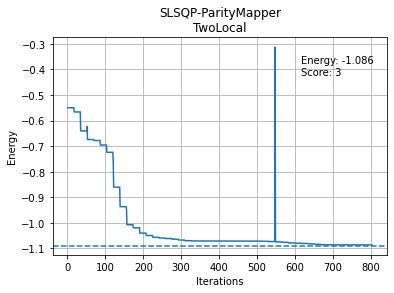

In [23]:
ansatz_type = 'TwoLocal'

# Store results in a dictionary
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

# Unroller transpile your circuit into CNOTs and U gates
pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz)
cnots = ansatz_tp.count_ops()['cx']
score = cnots

accuracy_threshold = 4.0 # in mHa
energy = result.optimal_value

if ansatz_type == "TwoLocal":
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': rotation_blocks,
        'entanglement_blocks': entanglement_blocks,
        'entanglement': entanglement,
        'repetitions': repetitions,
        'skip_final_rotation_layer': skip_final_rotation_layer,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}
else:
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': None,
        'entanglement_blocks': None,
        'entanglement': None,
        'repetitions': None,
        'skip_final_rotation_layer': None,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}

# Plot the results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy')
ax.grid()
fig.text(0.7, 0.75, f'Energy: {result.optimal_value:.3f}\nScore: {score:.0f}')
plt.title(f"{result_dict['optimizer']}-{result_dict['mapping']}\n{result_dict['ansatz']}")
ax.plot(counts, values)
ax.axhline(exact_energy, linestyle='--')
fig_title = f"\
{result_dict['optimizer']}-\
{result_dict['mapping']}-\
{result_dict['ansatz']}-\
Energy({result_dict['energy (Ha)']:.3f})-\
Score({result_dict['score']:.0f})\
.png"
fig.savefig(fig_title, dpi=300)

# Display and save the data
import pandas as pd
import os.path
filename = 'results_final.csv'
if os.path.isfile(filename):
    result_df = pd.read_csv(filename)
    result_df = result_df.append([result_dict])
else:
    result_df = pd.DataFrame.from_dict([result_dict])
result_df.to_csv(filename)
result_df[['optimizer','ansatz', '# of qubits', '# of parameters','rotation blocks', 'entanglement_blocks',
    'entanglement', 'repetitions', 'error (mHa)', 'pass', 'score']]